In [1]:
from matplotlib import pyplot as plt
import numpy as np
np.set_printoptions(precision=1, suppress=True)

# Knight and the Princess: Q-Table Learning
![Knight and the Princess](https://cdn-images-1.medium.com/max/800/1*h7B4EVx3B-sv5OvHH8nrNw.png)

In [2]:
class Environment():
    def __init__(self, i=0, j=0):
        """
        Parameters:
            state (int): 0<=state<=24, mapping to a 5x5 grid
        """
        self.rewards = np.array([
            [0, 0, 0, 0, 0],
            [0, -100, 0, -100, 0],
            [0, 0, 0, 0, 0],
            [0, -100, 0, -100, 0],
            [0, 0, 100, 0, 0]
        ])
        self.i = i
        self.j = j
        
    def random_valid_action(self):
        while True:
            action = np.random.randint(0, 4)
            if self.is_valid_action(action):
                return action
            
    def valid_actions(self):
        return [action for action in range(4) if self.is_valid_action(action)]
    
    def transition(self, i, j, action, slip):
        """
        Action must be a valid action.
        """
        if np.random.random() < slip:
            action = self.random_valid_action()
        
        if action == 0:
            j -= 1
        elif action == 1:
            j += 1
        elif action == 2:
            i -= 1
        elif action == 3:
            i += 1
        else:
            assert False, "Invalid action."
            
        return i, j
        
    def take_action(self, action, slip=0):
        """
        Parameters:
            action (int): 0<=action<=3, mapping to [left, right, up, down]
            slip (float): the probability of taking a random move (slipping).
        Returns
            new_state (int)
            reward (int): for being in the new state.
        """
        assert self.is_valid_action(action), "Invalid action. state ({},{}), action {}".format(self.i, self.j, action)
        
        self.i, self.j = self.transition(self.i, self.j, action, slip)
        
        # restart the game when reaching the princess
        if self.i == 4 and self.j == 2:
            self.i, self.j = 0, 0
            return 4, 2, self.rewards[4,2]
            
        return self.i, self.j, self.rewards[self.i,self.j]     
        
    def is_valid_action(self, action):
        if self.i == 0 and action == 2:
            return False
        if self.i == 4 and action == 3:
            return False
        if self.j == 0 and action == 0:
            return False
        if self.j == 4 and action == 1:
            return False
        return True     
    
    def get_state(self):
        return self.i, self.j

value of each state:
 [[58.1 64.9 72.4 64.7 57.8]
 [65.  72.6 80.8 72.5 64.2]
 [72.6 80.8 89.9 80.7 72.1]
 [79.7 89.9 99.9 89.5 74.6]
 [89.3 99.8  0.  98.9 87.8]] 



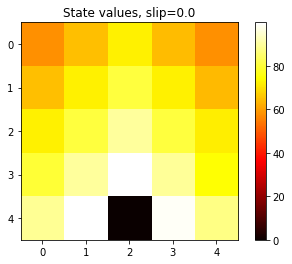

In [3]:
num_actions = 4 # indexed as [left, right, up, down]
Q_table = np.random.random((5, 5, num_actions))
Q_table[4,2,:] = 0

def choose_action(env, Q_table, i, j, epsilon=1.0):
    """
    Chooses an action based on the epsilon-greedy approach.
    """
    if np.random.random() < epsilon:
        while True:
            action = np.random.randint(0, 4)
            if env.is_valid_action(action):
                break
        return action
    else:
        cur_max = -np.inf
        for action in range(4):
            if env.is_valid_action(action):
                val = Q_table[i,j,action]
                if cur_max < val:
                    cur_max = val
                    max_action = action
        return max_action
       
def play(N=1000, alpha=0.1, gamma=0.9, slip=0):
    """
    Parameters:
        N (int): number of timesteps to play.
        alpha (float): the learning rate, in [0, 1].
        gamma (float): the discount factor, in [0, 1].
        slip (float): the probability of accidentally taking a random move.
    Returns:
        Q_table ((5,5,4) ndarray): the expected reward of being in a state,
            and taking an action.
        V ((5,5) ndarray): the expected reward of being in a state,
            and taking future actions.
    """
    env = Environment(i=0, j=0)
    for i in range(N):
        i, j = env.get_state()
        action = choose_action(env, Q_table, i, j)
        i_prime, j_prime, reward = env.take_action(action, slip=slip)
        Qprime_actions = Q_table[i_prime, j_prime, env.valid_actions()]
        Qprime = (1-slip)*np.max(Qprime_actions) + slip*np.mean(Qprime_actions)
        Q = Q_table[i, j, action]
#         print("before:", Q_table[i, j, action])
        Q_table[i, j, action] = Q + alpha*(reward + gamma*Qprime - Q)
#         print("after:", Q_table[i, j, action])

    V = np.max(Q_table, axis=2)
    
    return Q_table, V

def display_values(V, title):
    print("value of each state:\n", V, "\n")

    fig = plt.figure()
    ax = fig.add_subplot(111)
    img = ax.imshow(V, cmap='hot', interpolation='nearest')
    ax.set_title(title)
    plt.colorbar(img)
    plt.show()

Q_table, V = play(N=10000, slip=0)
display_values(V, title="State values, slip=0.0")

We see that the value of each state is precise gamma^n * 100, where gamma is the distance from the castle square. What if we add stochasticity? Fx, each move there's a 20% chance of slipping.

value of each state:
 [[ 8.7  8.9 15.3 16.5 18. ]
 [17.3 19.1 30.8 17.1 10.3]
 [24.1 30.1 47.2 24.1 34.1]
 [35.5 67.5 85.2 64.8 46.7]
 [62.2 96.2  0.  95.4 66.7]] 



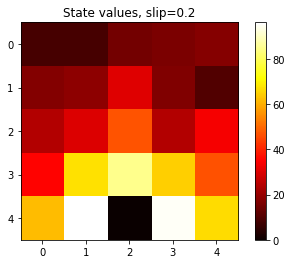

In [4]:
Q_table, V = play(N=10000, slip=0.2)
display_values(V, title="State values, slip=0.2")

value of each state:
 [[  0.8   0.1   0.7   0.7   0.3]
 [  0.1 -59.7 -55.8 -51.4   0.4]
 [  0.4 -56.   -1.9 -39.4   0.7]
 [  1.    1.3  46.6  16.    0.3]
 [ 14.3  46.9   0.   47.8  38.3]] 



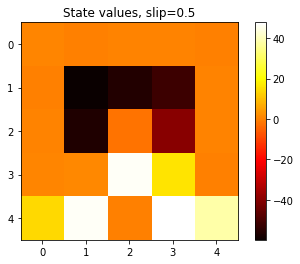

In [5]:
Q_table, V = play(N=10000, slip=0.5)
display_values(V, title="State values, slip=0.5")

value of each state:
 [[   0.8    0.1    0.7    0.7    0.3]
 [   0.1 -143.6 -152.3 -136.6    0.4]
 [   0.4 -137.3 -112.9 -136.5    0.7]
 [   1.   -74.2  -89.9  -67.     0.3]
 [   0.8    0.2    0.     9.4    0.9]] 



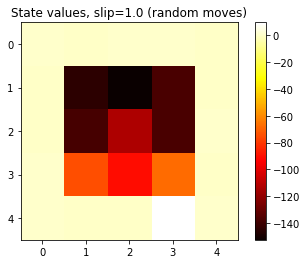

In [6]:
Q_table, V = play(N=10000, slip=1.0)
display_values(V, title="State values, slip=1.0 (random moves)")